```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018, 2019 Norwegian Meteorological Institute

This notebook runs a performance benchmark for the CDKLM scheme using
several of the components for realistic simulations

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Numerical Order - nontrivial parameters


## Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc, colors, cm
from matplotlib import pyplot as plt

import os
import datetime
import time
import gc
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(6.0, 4.0))
rc('animation', html='html5')
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'


#Import our simulator
from SWESimulators import FBL, CTCS,KP07, CDKLM16, PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
%setup_logging
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger disabled
Python version 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Registering gpu_ctx in user workspace
PyCUDA version 2019.1.2
CUDA version (10, 1, 0)
Driver version 10010
Using 'Tesla P100-PCIE-12GB' GPU
Created context handle <94632138636016>


In [3]:
!nvidia-smi

Sat Nov 23 19:00:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |    263MiB / 12198MiB |      9%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
#Create output directory for images

#imgdir='images_convergence_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
#os.makedirs(imgdir)

imgdir = 'images_convergence_2019_11_06-10_53_52'

print("Saving images to " + imgdir)

Saving images to images_convergence_2019_11_06-10_53_52


In [5]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       #cycler('markersize', [15, 15, 15, 15, 15, 15]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k']) )

8.092556560821176 -6.541861464796368


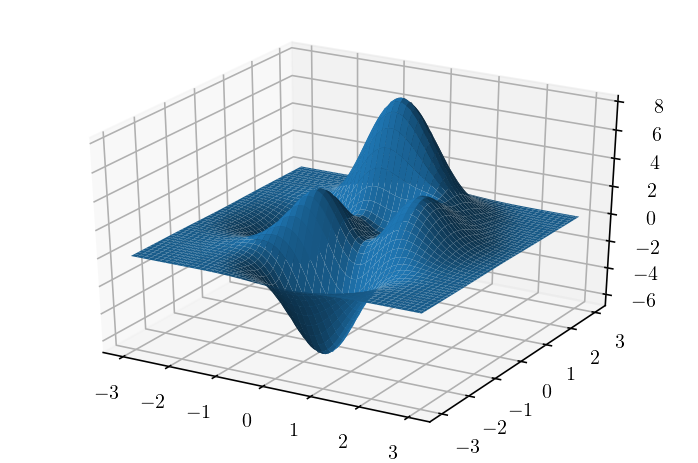

In [6]:
def peaks(nx, ny):
    x = np.linspace(-3, 3, nx)
    y = np.linspace(-3, 3, ny)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2*np.exp(-(x**2) - (y+1)**2) - 10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3*np.exp(-(x+1)**2-y**2)
    x = None
    y = None
    gc.collect()
    return z


from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
nx = 100
ny = 100
z = peaks(nx, ny)
x = np.linspace(-3, 3, nx)
y = np.linspace(-3, 3, ny)
x, y = np.meshgrid(x, y)
ax.plot_surface(x, y, z)

print(np.max(z), np.min(z))

In [7]:
width = 500000
height = 500000

domain_min = 16
domain_max = 8192*2
    
g = 9.81
r = 0.00

end_time = 1600.0

In [8]:
def averageFV(highres_solution, factor, symmetry=False):
    retval = highres_solution.copy().astype(np.float64)
    NX = retval.shape[1]
    NY = retval.shape[0]
    
    assert(NY % factor == 0)
    assert(NX % factor == 0)
    
    nx = int(NX / factor)
    ny = int(NY / factor)
    
    factor = int(factor)
    
    retval = retval.reshape([ny, factor, nx, factor]).mean(3).mean(1)
    if (symmetry):
        retval = 0.5*(retval +  retval[::-1, ::-1]) #Symmetry
    
    return retval.astype(np.float32)


def averageFD(highres_solution, factor, symmetry=False):
    retval = highres_solution.copy().astype(np.float64)
    target = retval.shape[0] / factor
    #while (retval.shape[0] > (target+1)):
    for i in range(int(np.log2(factor))):
        retval = retval[::2, ::2]
    if (symmetry):
        retval = 0.5*(retval +  retval[::-1, ::-1]) #Symmetry
    
    return retval.astype(np.float32)

def addGhosts(highres_solution):
    NX = highres_solution.shape[1] + 4
    NY = highres_solution.shape[0] + 4
    
    retval = np.empty((NY, NX), dtype=np.float32)    
    retval[2:-2, 2:-2] = highres_solution
    retval[0,:] = retval[3,:]
    retval[1,:] = retval[2,:]
    retval[-2,:] = retval[-3,:]
    retval[-1,:] = retval[-4,:]
    retval[:,0] = retval[:,3]
    retval[:,1] = retval[:,2]
    retval[:,-2] = retval[:,-3]
    retval[:,-1] = retval[:,-4]
    
    return retval

FV: Max=1.00000, min=0.00000, sum=88159.9603261668
FV: Max=1.00000, min=0.00000, sum=22039.9900815417
FV: Max=1.00000, min=0.00000, sum=5509.9975203854
FV: Max=1.00000, min=0.00000, sum=1377.4993800964
Angle: Max=0.98279, min=0.58800, sum=823549.6645826453
Angle: Max=0.98279, min=0.58800, sum=205887.4161456613
Angle: Max=0.98279, min=0.58800, sum=51471.8540364153
Angle: Max=0.98279, min=0.58800, sum=12867.9635091038


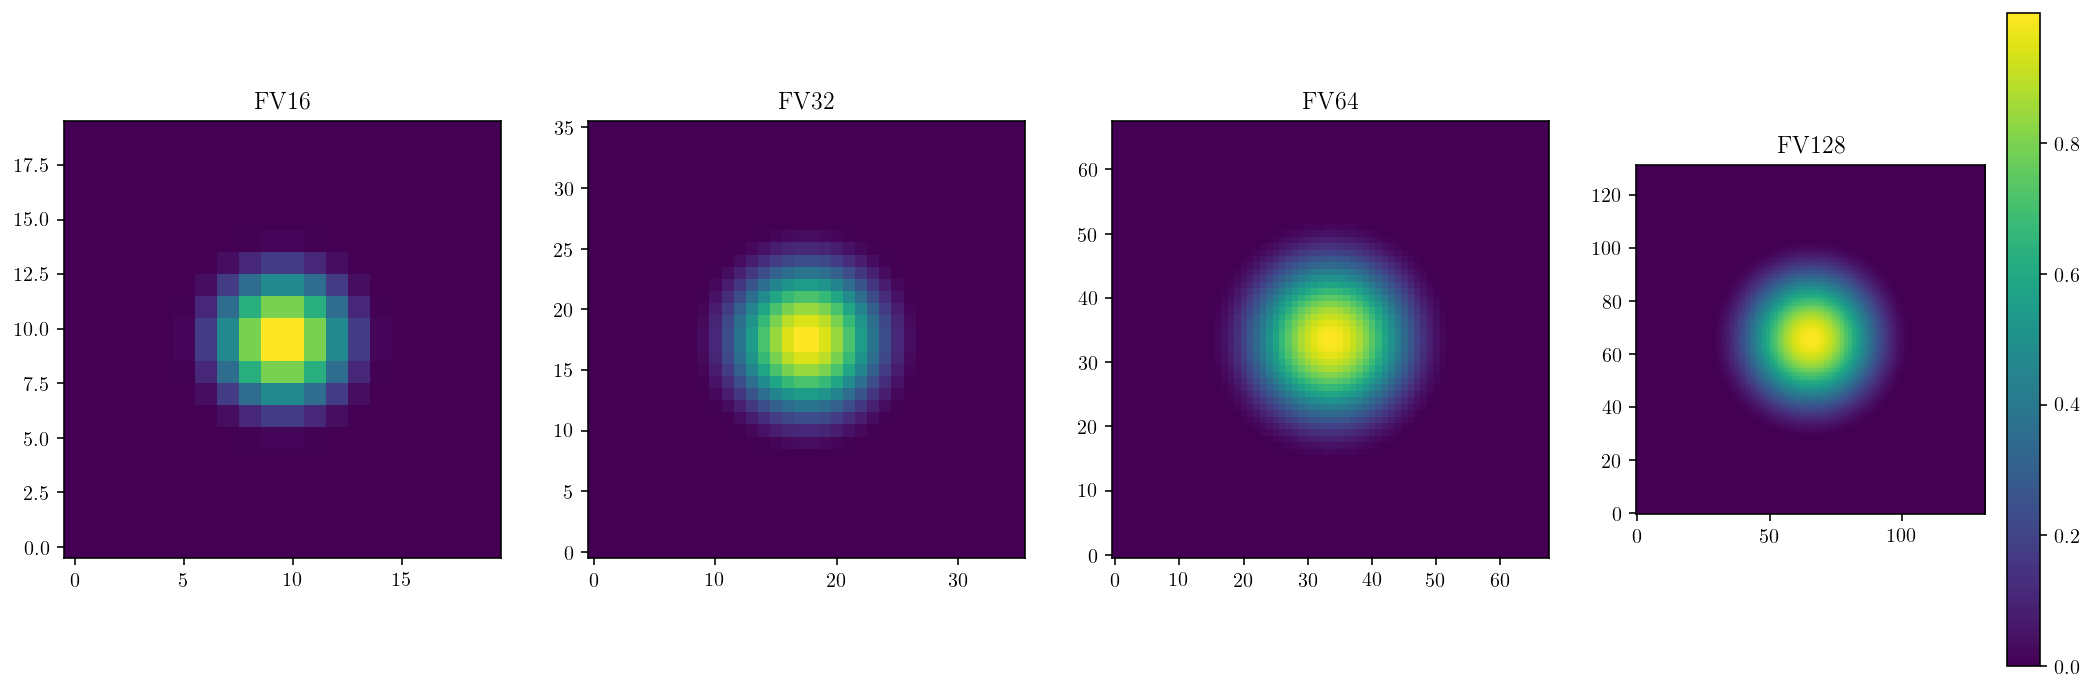

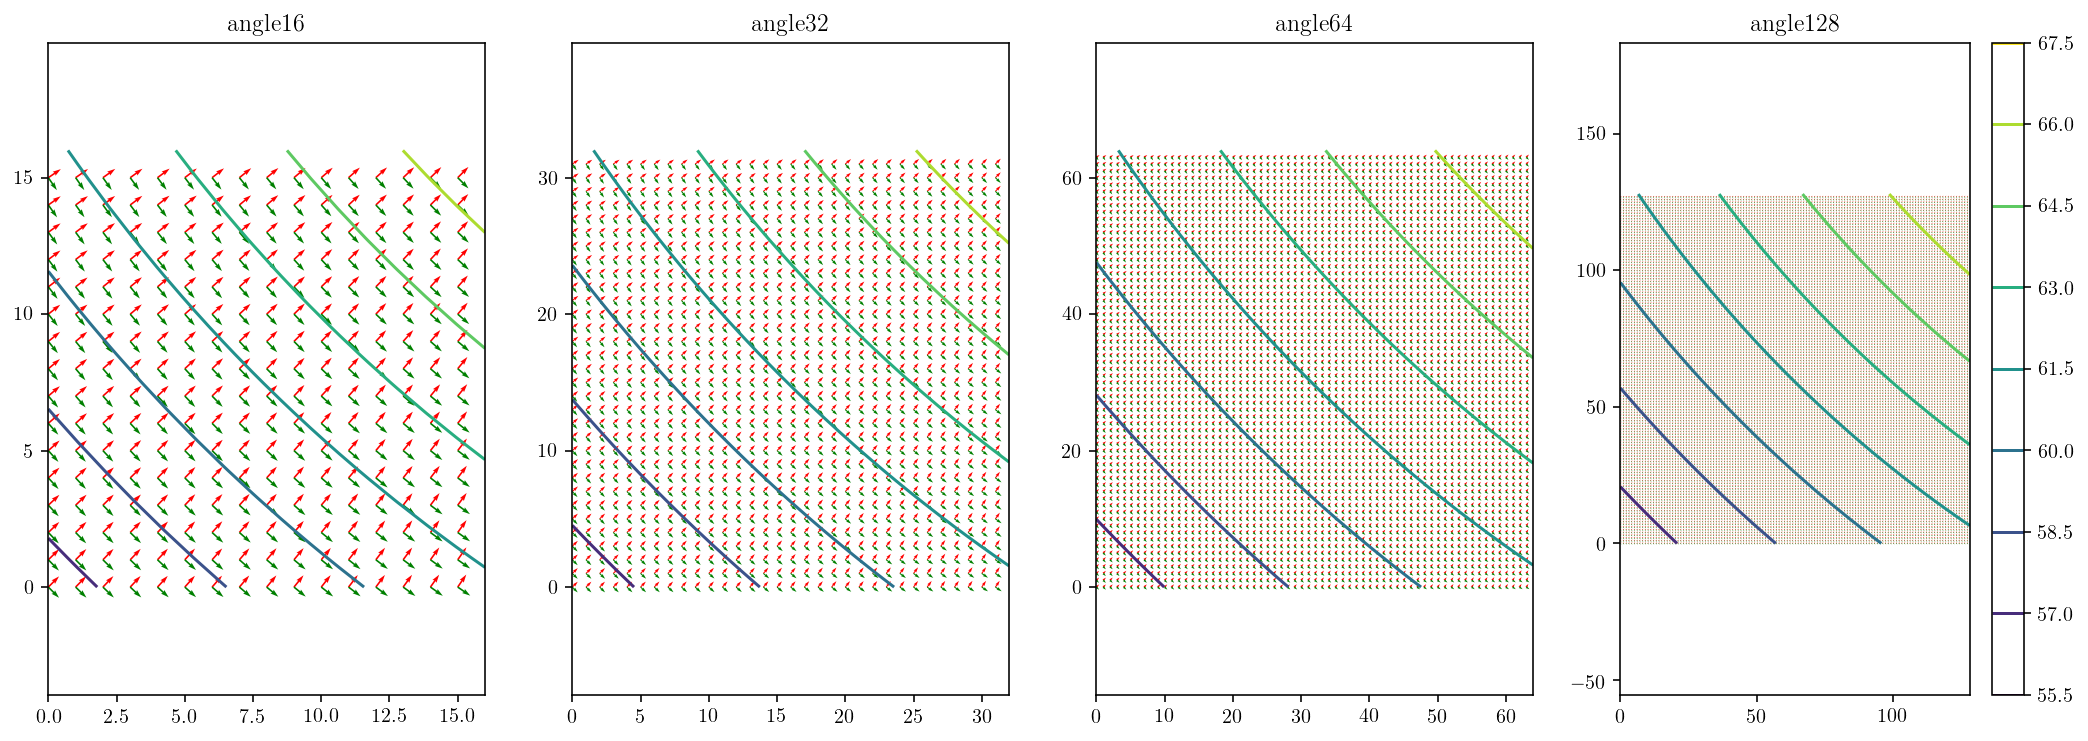

In [9]:
def initH(h0):
    nx = h0.shape[1]
    ny = h0.shape[0]
    
    h0 = 100 + 10*peaks(nx, ny)
    
    return h0

def initAngleLatitude(angle, latitude):
    nx = angle.shape[1]
    ny = angle.shape[0]
    
    x = np.linspace(0, 20000, nx)
    y = np.linspace(0, 20000, ny)

    x, y = np.meshgrid(x, y)

    x0, y0 = 3.0*20000, 3.0*20000
    x, y = x0-x, y0-y

    angle = np.arctan2(x, y)
    lat = 90-np.sqrt(x**2 + y**2)/2500
    
    return angle, lat
    
    
def initEtaFV(eta0):
    nx = eta0.shape[1]
    ny = eta0.shape[0]
    
    def my_cos(i, j):
        size = 0.6
        x = 2*(i + 0.5 - nx/2.0) / float(nx)
        y = 2*(j + 0.5 - ny/2.0) / float(ny)
        r = np.sqrt(x**2 + y**2)
        return (1.0 + np.cos(np.pi*r/size)) * (r < size)
    
    #Generate disturbance 
    eta0 = 0.5 * np.fromfunction(lambda i, j: my_cos(i,j), (ny, nx))
    
    #Make sure solution is symmetric
    
    disturbance = None
    gc.collect()
    
    return eta0
    

    
def initHU(hu0):
    hu0.fill(0.0)
    return hu0
    
def initHV(hv0):
    hv0.fill(0.0)
    return hv0

    
plt.figure(figsize=(18,6))
eta0 = np.zeros((domain_max, domain_max), dtype=np.float32)
eta0 = initEtaFV(eta0)
for i in range(4):
    domain_size = domain_min*2**i
    plt.subplot(1, 4, i+1)
    plt.imshow(addGhosts(averageFV(eta0, domain_max//domain_size)), interpolation='nearest', origin='lower')
    plt.title("FV"+str(domain_size))
    print("FV: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(eta0), np.min(eta0), np.sum(eta0/(domain_size*domain_size))))
plt.colorbar()
    
plt.figure(figsize=(18,6))
angle = np.empty((domain_max, domain_max))
lat = np.empty((domain_max, domain_max))
angle, lat = initAngleLatitude(angle, lat)
for i in range(4):
    domain_size = domain_min*2**i
    plt.subplot(1, 4, i+1)
    #plt.imshow(angle, interpolation='nearest', origin='lower')
    #plt.contour(angle, colors='k', alpha=0.2, linewidths=0.8)
    a = averageFV(angle, domain_max//domain_size)
    l = averageFV(lat, domain_max//domain_size)
    plt.quiver(np.sin(a), np.cos(a), color='r')
    plt.quiver(np.cos(a), -np.sin(a), color='g')
    plt.contour(l, extent=[0, domain_size, 0, domain_size])
    plt.axis('equal')
    plt.title("angle"+str(domain_size))
    print("Angle: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(angle), np.min(angle), np.sum(angle/(domain_size*domain_size))))
plt.colorbar()

In [10]:
def plotData(eta0, u0, v0, eta1, u1, v1):
    fig, axarr = plt.subplots(2, 3, figsize=(12, 8))
    axarr[0, 0].imshow(eta0, interpolation="nearest")
    axarr[0, 1].imshow(u0, interpolation="nearest")
    axarr[0, 2].imshow(v0, interpolation="nearest")
    axarr[1, 0].imshow(eta1, interpolation="nearest")
    axarr[1, 1].imshow(u1, interpolation="nearest")
    axarr[1, 2].imshow(v1, interpolation="nearest")
    print("Eta0: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta0), np.min(eta0)))
    print("Eta1: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta1), np.min(eta1)))

## CDKLM 16

In [11]:
def benchmarkCDKLM(cdklm_filename, plot=False):
    
    #Run all domain sizes 
    data = {'domain_size': [], 't_dl': [], 't_sim': []};
    domain_size = domain_min
    
    reference_domain_size = domain_min
    while (reference_domain_size <= domain_max):
        reference_domain_size *= 2
        
    print("Using reference domain size " + str(reference_domain_size))
        
    #Allocate data
    Hi_ref = np.zeros((reference_domain_size+1, reference_domain_size+1), dtype=np.float32)
    eta0_ref = np.zeros((reference_domain_size, reference_domain_size), dtype=np.float32);
    #hu0_ref = np.zeros((reference_domain_size, reference_domain_size), dtype=np.float32);
    #hv0_ref = np.zeros((reference_domain_size, reference_domain_size), dtype=np.float32);
    angle_ref = np.zeros((128, 128), dtype=np.float32);
    lat_ref = np.zeros((128, 128), dtype=np.float32)
    
    #Initialize
    Hi_ref = initH(Hi_ref)
    eta0_ref = initEtaFV(eta0_ref)
    #hu0_ref = initHU(hu0_ref)
    #hv0_ref = initHV(hv0_ref)
    angle_ref, lat_ref = initAngleLatitude(angle_ref, lat_ref)
    
    def runCDKLM(domain_size, reference_domain_size):
        #Clean up old simulator if any:
        if 'cdklm_sim' in globals():
            cdklm_sim.cleanUp()

        nx = domain_size
        ny = domain_size

        dx = float(width/nx)
        dy = float(height/ny)
        dt = end_time / domain_size
        
        Hi = addGhosts(averageFD(Hi_ref, reference_domain_size//domain_size))
        eta0 = addGhosts(averageFV(eta0_ref, reference_domain_size//domain_size))
        hu0 = np.zeros_like(eta0)
        hv0 = np.zeros_like(eta0)
        angle = angle_ref.copy()
        lat = lat_ref.copy()

        #Initialize simulator
        cdklm_sim = CDKLM16.CDKLM16(gpu_ctx, 
                      eta0, hu0, hv0, Hi, 
                      nx, ny, 
                      dx, dy, dt, 
                      g, 0.0, #f=0.0, calculated from latitude
                      r,
                      angle=angle, latitude=lat)
        
        pre_sim = time.time()
        t = cdklm_sim.step(end_time)
        gpu_ctx.synchronize()
        post_sim = time.time()
        eta1, hu1, hv1 = cdklm_sim.download()
        post_dl = time.time()
        Hi, Hm = cdklm_sim.downloadBathymetry()
        t_sim = post_sim-pre_sim
        t_dl = post_dl-post_sim
        print("{:s}: Domain size={:d}, t={:f}, nt={}, eta=[{:f}, {:f}], Hi=[{:f}, {:f}], T_sim={:f}, T_dl={:f}".format(
            str(datetime.datetime.now()), domain_size, t, cdklm_sim.num_iterations, np.min(eta1), np.max(eta1), np.min(Hi), np.max(Hi), t_sim, t_dl
        ))

        
        if (plot==True):
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(25, 45)
            ax.pbaspect = [2.0, 2.0, 0.25]
            x = np.linspace(0, nx*dx, nx)
            y = np.linspace(0, ny*dy, ny)
            x, y = np.meshgrid(x, y)
            
            ls = colors.LightSource(270, 5)
            
            eps = 0.0
            
            ghosts = [2, 2, 2, 2]
            
            ax.plot_surface(x, y, eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], cmap=cm.gist_ncar, edgecolor=None, shade=True, alpha=0.7, vmin=0, vmax=0.7, lightsource=ls)
            ax.contour(x, y, eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]+eps, colors='k', levels=np.linspace(-1.0, 1.0, 20)+eps)
            
            ax.plot_surface(x, y, -Hm[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], cmap=cm.gist_earth, edgecolor=None, shade=True, alpha=0.9, lightsource=ls)
            ax.contour(x, y, -Hm[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]+eps, colors='k', levels=np.linspace(-180, -40, 14)+eps)

        return [t_sim, t_dl]
        #return [eta0, hu0, hv0, eta1, hu1, hv1]


    #Run all domain sizes 
    data = {'domain_size': [], 't_dl': [], 't_sim': []};
    domain_size = domain_min
    
    reference_domain_size = domain_min
    while (reference_domain_size <= domain_max):
        reference_domain_size *= 2
        
    while (domain_size <= domain_max):
        t_sim, t_dl = runCDKLM(domain_size, reference_domain_size)
        data['domain_size'] += [domain_size]
        data['t_sim'] += [t_sim]
        data['t_dl'] += [t_dl]
        domain_size = domain_size*2

        #Save to file
        np.savez_compressed(cdklm_filename, **data)
    
    
cdklm_filename = imgdir + "/CDKLM_data.npz"
benchmarkCDKLM(cdklm_filename)

Using reference domain size 32768


Subsampling angle texture by factor 10
This will give inaccurate angle along the border!
Subsampling coriolis texture by factor 10
This will give inaccurate coriolis along the border!


2019-11-23 19:04:51.738865: Domain size=16, t=1600.000000, nt=16, eta=[-0.000003, 0.424514], Hi=[38.134552, 179.966202], T_sim=0.002254, T_dl=0.000164


Subsampling angle texture by factor 10
This will give inaccurate angle along the border!
Subsampling coriolis texture by factor 10
This will give inaccurate coriolis along the border!


2019-11-23 19:05:03.532313: Domain size=32, t=1600.000000, nt=32, eta=[-0.000004, 0.460379], Hi=[35.098377, 179.966202], T_sim=0.004314, T_dl=0.000170


Subsampling angle texture by factor 10
This will give inaccurate angle along the border!
Subsampling coriolis texture by factor 10
This will give inaccurate coriolis along the border!


2019-11-23 19:05:15.667169: Domain size=64, t=1600.000000, nt=64, eta=[-0.000005, 0.467831], Hi=[34.842125, 181.030853], T_sim=0.008162, T_dl=0.000163
2019-11-23 19:05:26.913256: Domain size=128, t=1600.000000, nt=128, eta=[-0.000005, 0.469719], Hi=[34.528316, 181.030853], T_sim=0.015937, T_dl=0.000197
2019-11-23 19:05:38.596765: Domain size=256, t=1600.000000, nt=256, eta=[-0.000009, 0.470196], Hi=[34.500393, 181.034698], T_sim=0.030849, T_dl=0.000372
2019-11-23 19:05:50.418066: Domain size=512, t=1600.000000, nt=512, eta=[-0.000011, 0.470333], Hi=[34.492626, 181.061584], T_sim=0.159795, T_dl=0.000946
2019-11-23 19:06:03.888282: Domain size=1024, t=1600.000000, nt=1024, eta=[-0.000012, 0.470371], Hi=[34.489544, 181.061584], T_sim=1.096944, T_dl=0.002232
2019-11-23 19:06:25.561629: Domain size=2048, t=1600.000000, nt=2048, eta=[-0.000012, 0.470375], Hi=[34.488705, 181.062042], T_sim=8.387191, T_dl=0.018638
2019-11-23 19:07:48.203463: Domain size=4096, t=1600.000000, nt=4096, eta=[-0.00

[   32    64   128   256   512  1024  2048  4096  8192 16384]
[1.91359069 1.89222351 1.95244772 1.93567111 5.18000124 6.86468377
 7.64595992 8.02934222 7.96671731 7.99750158]
[1.03193033 0.96202532 1.20760234 1.89104116 2.5396927  2.35971767
 8.35103087 4.27069102 4.02691871 3.80966443]


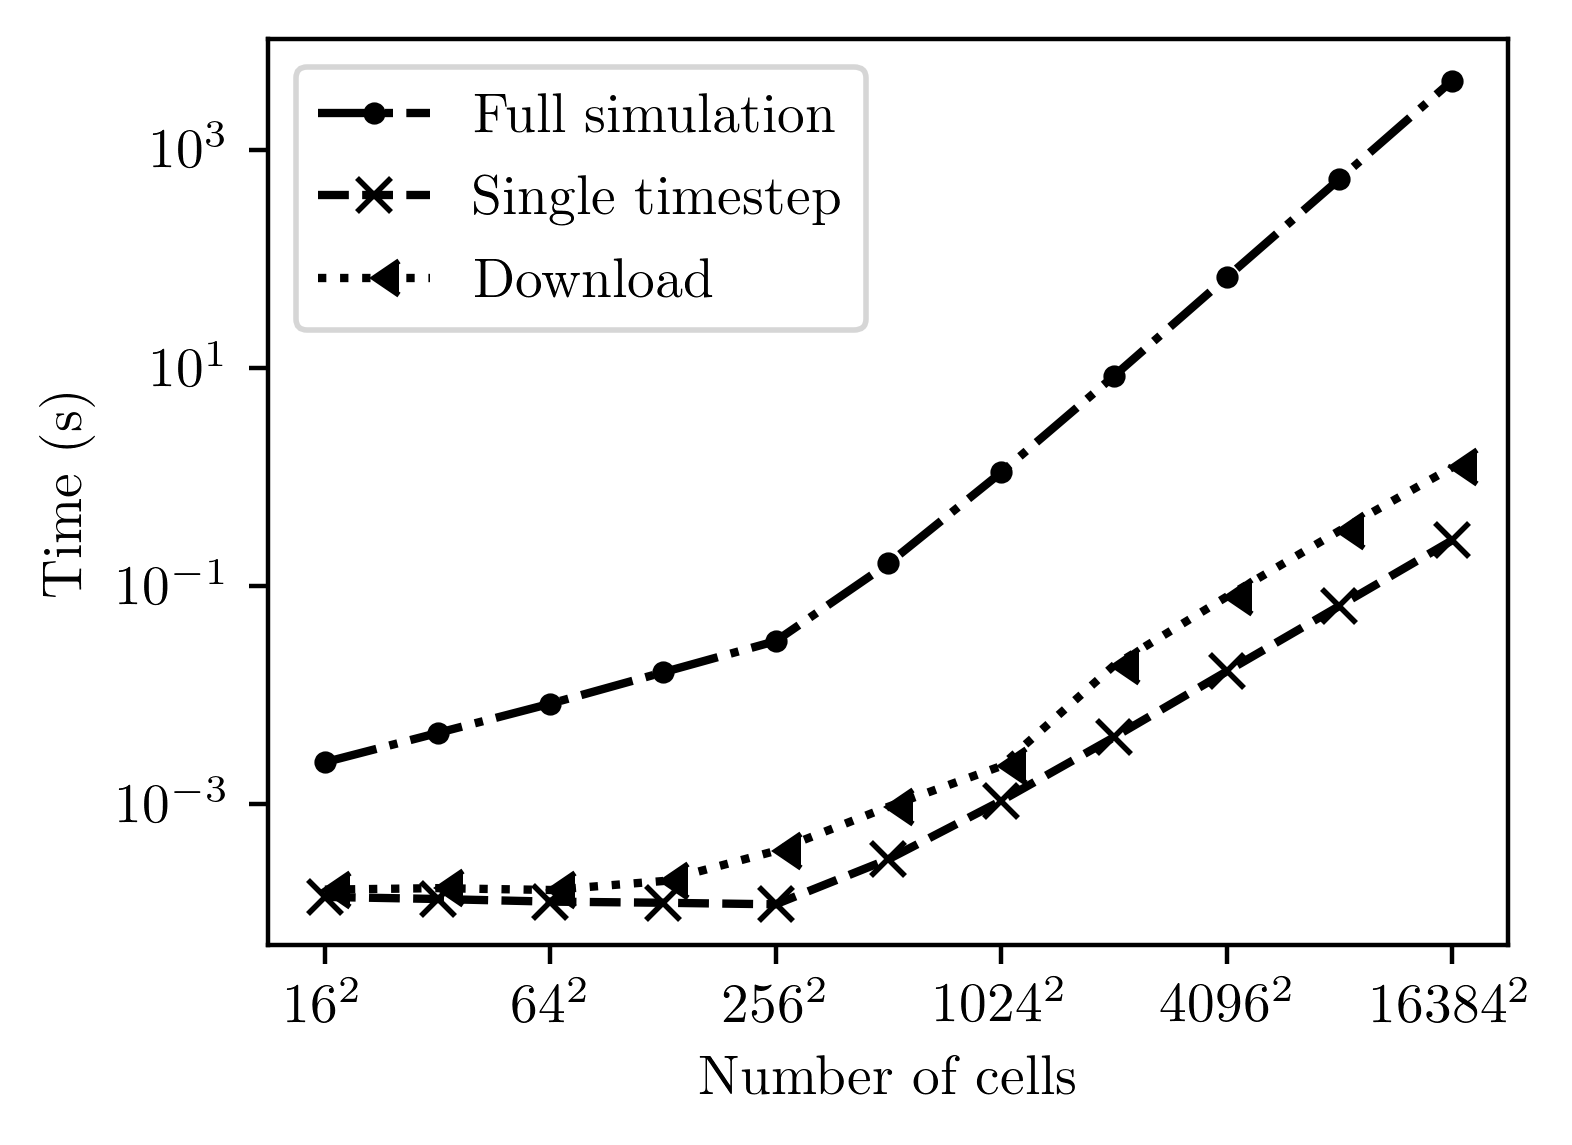

In [12]:

cdklm_filename = imgdir + "/CDKLM_data.npz"


with np.load(cdklm_filename) as npzfile:
    #Get all domain sizes in file
    domain_size = npzfile['domain_size']
    t_sim = npzfile['t_sim']
    t_dl = npzfile['t_dl']
    
    begin = 0
    domain_size = domain_size[begin:]
    t_sim = t_sim[begin:]
    t_dl = t_dl[begin:]
    
    x = domain_size * domain_size
    cells = x * domain_size #nx*ny*nt
    fig = plt.figure(figsize=(4, 3), dpi=200)
    setBwStyles(fig.gca())
    plt.loglog(x, t_sim+t_dl, label='Full simulation')
    plt.loglog(x, t_sim/domain_size, label='Single timestep')
    plt.loglog(x, t_dl, label='Download')
    #plt.loglog(x, t_dl+t_sim, 'gx-',)
    plt.xlabel('Number of cells')
    
    x = x[::2]
    plt.xticks(x, ["$" + str(s) + "^2$" for s in domain_size[::2]])
    plt.minorticks_off()
    plt.ylabel('Time (s)')
    plt.legend()
    plt.savefig(imgdir + '/performance.pdf', bbox_inches = "tight")
    
    print(domain_size[1:])
    print(t_sim[1:] / t_sim[:-1])
    print(t_dl[1:] / t_dl[:-1])

In [13]:
print(imgdir)

images_convergence_2019_11_06-10_53_52
